[('DeletionFlag', 'C', 1, 0), ['STATEFP20', 'C', 2, 0], ['COUNTYFP20', 'C', 3, 0], ['COUNTYNS20', 'C', 8, 0], ['GEOID20', 'C', 5, 0], ['NAME20', 'C', 100, 0], ['NAMELSAD20', 'C', 100, 0], ['LSAD20', 'C', 2, 0], ['CLASSFP20', 'C', 2, 0], ['MTFCC20', 'C', 5, 0], ['CSAFP20', 'C', 3, 0], ['CBSAFP20', 'C', 5, 0], ['METDIVFP20', 'C', 5, 0], ['FUNCSTAT20', 'C', 1, 0], ['ALAND20', 'N', 14, 0], ['AWATER20', 'N', 14, 0], ['INTPTLAT20', 'C', 11, 0], ['INTPTLON20', 'C', 12, 0]]


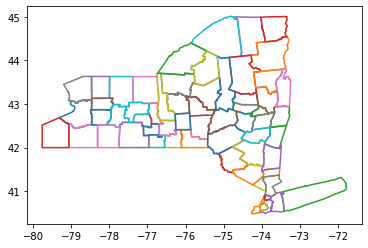

In [4]:
# import shapefile as shp
# import matplotlib.pyplot as plt

# sf = shp.Reader("C:/Users/juliu/OneDrive/Desktop/Classes/Fall 2022/ECON 420/Jupyter Notebook/tl_2020_36_county20/tl_2020_36_county20.shp")

# print(sf.fields)

# plt.figure()
# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x,y)
# plt.show()

In [1]:
#import statements
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from time import strftime

import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

In [8]:
#data importing and treatment
variables = pd.read_csv("C:/Users/juliu/OneDrive/Desktop/Classes/Fall 2022/ECON 420/acs_cleaned.csv")
data = np.empty([len(variables.columns), len(variables[variables.columns[1]])])
for i in range(1, len(variables.columns)):
        data[i] = variables[variables.columns[i]]

targets = pd.read_csv("C:/Users/juliu/OneDrive/Desktop/Classes/Fall 2022/ECON 420/election_targets.csv")
target = targets.prop_dem
perc_dem = targets.prop_dem * 100


X_train_full, X_test, y_train_full, y_test = train_test_split(data, target, test_size = 0.25, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

228


In [11]:
#MLP model
mlp_reg = MLPRegressor(hidden_layer_sizes=[25, 25, 25], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

y_pred_test = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test, squared=True)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(rmse)
print(mse_test)
print(rmse_test)

0.13641667556801043
0.028584916868236557
0.16907074515786744


In [6]:
#optimizing hyperparameters
def model_builder(hp):
    n_hidden = hp.Int("n_hidden", min_value = 0, max_value = 8)
    n_neurons = hp.Int("n_neurons", min_value = 30, max_value = 300)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-1, sampling = "log")
    optimizer = hp.Choice("optimizer", values = ["adam", "sgd"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
        
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
    
    return model

random_search_tuner = kt.RandomSearch(
    model_builder, objective = kt.Objective("val_root_mean_squared_error", direction="min"), max_trials = 10, overwrite = True,
    directory = "election_mnist", project_name = "election_pred", seed = 42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid), batch_size = 15)

Trial 10 Complete [00h 00m 03s]
val_root_mean_squared_error: 0.3842501938343048

Best val_root_mean_squared_error So Far: 0.3842501938343048
Total elapsed time: 00h 00m 30s
INFO:tensorflow:Oracle triggered exit


In [7]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 4
n_neurons: 96
learning_rate: 0.08611217825990654
optimizer: adam
Score: 0.3842501938343048


In [342]:
#optimized sequential model
tf.random.set_seed(42)

model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004410354359965501)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), batch_size = 20)
mse_test, rmse_test = model.evaluate(X_test, y_test)
print(mse_test)
print(rmse_test)

model_name = "optimized model"
model_version = "final"
model_path = Path(model_name) / model_version
model.save(model_path, save_format="tf")

Epoch 1/20
12/12 [==============================] - 2s 25ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0085 - val_root_me

INFO:tensorflow:Assets written to: optimized model\final\assets


INFO:tensorflow:Assets written to: optimized model\final\assets


In [343]:
#experimental sequential model 1
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model_exp1 = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(170, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(170, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(170, activation="relu"),    
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(170, activation="relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_exp1.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model_exp1.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), batch_size = 20)
mse_test, rmse_test = model_exp1.evaluate(X_test, y_test)
print(mse_test)
print(rmse_test)

model_exp1_name = "experimental model 1"
model_exp1_version = "final"
model_exp1_path = Path(model_exp1_name) / model_exp1_version
model_exp1.save(model_exp1_path, save_format="tf")

Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 2/20
12/12 [==============================] - 0s 11ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0080 - val_root_mea

INFO:tensorflow:Assets written to: experimental model 1\final\assets


INFO:tensorflow:Assets written to: experimental model 1\final\assets


In [344]:
#experimental sequential model 2
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model_exp2 = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_exp2.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model_exp2.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), batch_size = 20)
mse_test, rmse_test = model_exp2.evaluate(X_test, y_test)
print(mse_test)
print(rmse_test)

model_exp2_name = "experimental model 2"
model_exp2_version = "final"
model_exp2_path = Path(model_exp2_name) / model_exp2_version
model_exp2.save(model_exp2_path, save_format="tf")

Epoch 1/20
12/12 [==============================] - 1s 18ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 3/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 4/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 5/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 6/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0096 - val_root_mean_s

INFO:tensorflow:Assets written to: experimental model 2\final\assets


INFO:tensorflow:Assets written to: experimental model 2\final\assets


In [337]:
#displaying in tensorboard
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb], batch_size = 20)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model_exp1.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb], batch_size = 20)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model_exp2.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb], batch_size = 20)


Epoch 1/20
12/12 [==============================] - 2s 25ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 6/20
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0084 - val_root_m

Epoch 9/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 10/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 11/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 12/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 13/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 14/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0099 - val_root_me